# 01. Ridge and Lasso Regression | الانحدار ريدج ولاسو

## 📚 Prerequisites (What You Need First) | المتطلبات الأساسية

**BEFORE starting this notebook**, you should have completed:
- ✅ **Unit 1: All examples** - Data processing, linear regression, polynomial regression
- ✅ **Understanding of overfitting**: What happens when models are too complex
- ✅ **Basic linear algebra**: Understanding coefficients and regularization

**If you haven't completed these**, you might struggle with:
- Understanding why regularization is needed
- Knowing when to use Ridge vs Lasso
- Understanding how alpha (regularization strength) works

---

## 🔗 Where This Notebook Fits | مكان هذا الدفتر

**This is Unit 2, Example 1** - it solves the overfitting problem from polynomial regression!

**Why this example FIRST in Unit 2?**
- **Before** you can use advanced techniques, you need to solve overfitting
- **Before** you can build robust models, you need regularization
- **Before** you can handle multicollinearity, you need Ridge/Lasso

**Builds on**: 
- 📓 Unit 1, Example 4: Linear Regression (we know basic regression)
- 📓 Unit 1, Example 5: Polynomial Regression (we saw overfitting!)

**Leads to**: 
- 📓 Example 2: Cross-Validation (evaluates models properly)
- 📓 Unit 3: Classification (same regularization concepts apply)
- 📓 All ML models (regularization is universal!)

**Why this order?**
1. Ridge/Lasso solve **overfitting** (critical problem from Unit 1)
2. Ridge/Lasso teach **regularization** (essential ML concept)
3. Ridge/Lasso show **feature selection** (Lasso automatically selects features)

---

## The Story: Preventing Overfitting | القصة: منع الإفراط في التلائم

Imagine you're learning to drive. **Before** regularization, you memorize every turn on the training route perfectly, but fail on new routes (overfitting). **After** regularization, you learn general driving principles that work everywhere!

Same with machine learning: **Before** Ridge/Lasso, models memorize training data perfectly but fail on new data. **After** Ridge/Lasso, models learn general patterns that generalize well!

---

## Why Ridge and Lasso Matter | لماذا يهم ريدج ولاسو؟

Regularization prevents overfitting:
- **Ridge (L2)**: Shrinks coefficients toward zero (keeps all features)
- **Lasso (L1)**: Shrinks some coefficients to exactly zero (feature selection!)
- **Both**: Prevent overfitting by penalizing large coefficients
- **Alpha**: Controls regularization strength (higher = more regularization)

---

## 🌍 Real-World Applications | التطبيقات في الحياة الواقعية

**Ridge and Lasso Regression are used when you have MANY features or risk of overfitting!** Here's where you'll find them:

### 💰 Finance & Banking Sector | القطاع المالي والمصرفي
- **Credit Scoring**: Many features (income, age, credit history, employment, etc.) → Ridge/Lasso prevents overfitting
- **Stock Price Prediction**: Hundreds of market indicators → Lasso selects most important features
- **Risk Assessment**: Many risk factors → Ridge handles multicollinearity (correlated features)
- **Fraud Detection**: Many transaction features → Lasso automatically selects relevant features
- **Loan Default Prediction**: Multiple borrower characteristics → Regularization improves generalization

### 🏥 Healthcare & Medical Sector | القطاع الصحي والطبي
- **Disease Diagnosis**: Many symptoms, test results, patient data → Lasso selects key indicators
- **Drug Discovery**: Thousands of molecular features → Lasso identifies important compounds
- **Medical Imaging**: Many pixel/voxel features → Ridge prevents overfitting
- **Genomics**: Thousands of genes → Lasso selects relevant genes for disease prediction
- **Patient Outcome Prediction**: Many clinical variables → Ridge handles correlated features

### 📊 Marketing & E-commerce Sector | قطاع التسويق والتجارة الإلكترونية
- **Customer Segmentation**: Many customer attributes → Lasso selects key segmentation features
- **Churn Prediction**: Hundreds of customer behavior features → Lasso identifies important predictors
- **Recommendation Systems**: Many product/user features → Ridge prevents overfitting
- **Ad Click Prediction**: Many user, ad, context features → Lasso selects most relevant
- **Price Optimization**: Many market factors → Ridge handles multicollinearity

### 🏭 Manufacturing & Quality Control | التصنيع ومراقبة الجودة
- **Quality Prediction**: Many manufacturing parameters → Lasso selects critical parameters
- **Defect Detection**: Many sensor readings → Ridge prevents overfitting
- **Production Optimization**: Many process variables → Lasso identifies key factors
- **Supply Chain Forecasting**: Many demand factors → Ridge handles correlated features
- **Equipment Failure Prediction**: Many sensor features → Lasso selects important sensors

### 🔬 Scientific Research & Data Analysis | البحث العلمي وتحليل البيانات
- **Genomics Research**: Thousands of genes → Lasso selects relevant genes
- **Climate Modeling**: Many climate variables → Ridge handles multicollinearity
- **Material Science**: Many material properties → Lasso identifies key properties
- **Social Science Research**: Many survey variables → Ridge prevents overfitting
- **Epidemiology**: Many risk factors → Lasso selects important risk factors

### 🏛️ Government & Public Safety Sector (Ministry of Interior) | القطاع الحكومي والسلامة العامة (وزارة الداخلية)
- **Threat Assessment**: Many threat indicators → Lasso selects key threat factors → counter-terrorism
- **Traffic Prediction**: Many traffic sensors → Ridge handles correlated sensor data → traffic management
- **Crime Risk Models**: Many crime factors → Lasso identifies critical risk factors → crime prevention
- **Emergency Response**: Many emergency variables → Ridge handles multicollinearity → emergency services
- **Border Security Screening**: Many traveler features → Lasso selects important indicators → border control
- **Surveillance Systems**: Many surveillance features → Ridge prevents overfitting → security monitoring
- **Traffic Violation Detection**: Many violation factors → Lasso identifies key factors → traffic enforcement
- **Personnel Security**: Many personnel features → Ridge handles correlated features → internal organization
- **Access Control**: Many access factors → Lasso selects critical factors → government facilities
- **Traffic Flow Analysis**: Many traffic variables → Ridge handles multicollinearity → smart traffic systems

### 🎯 When to Use Ridge vs Lasso:
**Use RIDGE (L2) when:**
- ✅ All features might be important (don't want to remove any)
- ✅ Features are correlated (multicollinearity present)
- ✅ Want to keep all features but shrink coefficients
- ✅ Need stable, interpretable model
- ✅ **Example**: Medical diagnosis with many correlated symptoms

**Use LASSO (L1) when:**
- ✅ Want automatic feature selection (remove irrelevant features)
- ✅ Have many features, but only some are important
- ✅ Need simpler model (fewer features)
- ✅ Want to identify most important predictors
- ✅ **Example**: Genomics with thousands of genes, only few matter

**Use BOTH (Elastic Net) when:**
- ✅ Want benefits of both (feature selection + handling multicollinearity)
- ✅ Have many correlated features, but only some are important
- ✅ Need balanced approach

### 💡 Why Regularization is Critical:
- **Prevents Overfitting**: Models generalize better to new data
- **Handles Many Features**: Works well with high-dimensional data
- **Feature Selection (Lasso)**: Automatically identifies important features
- **Stability**: More stable predictions than unregularized models
- **Industry Standard**: Used in production ML systems worldwide

### 📈 When to Use Ridge/Lasso:
✅ **Use Ridge/Lasso when:**
- Have many features (more features than samples)
- Risk of overfitting (complex model, small dataset)
- Features are correlated (multicollinearity)
- Need feature selection (use Lasso)
- Want better generalization than linear regression

❌ **Don't use Ridge/Lasso when:**
- Have very few features (regularization not needed)
- Data is very large (overfitting less likely)
- Need all features (use Ridge, not Lasso)
- Simple linear relationship (regular linear regression sufficient)

---

## Learning Objectives | أهداف التعلم
1. Build Ridge regression models (L2 regularization)
2. Build Lasso regression models (L1 regularization)
3. Understand the difference between Ridge and Lasso
4. Tune alpha hyperparameter
5. Compare regularized models with linear regression
6. Understand when to use each method

In [14]:
# Step 1: Import necessary libraries
# These libraries help us build regularized regression models

import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For visualizations
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.linear_model import (
    LinearRegression,  # Baseline model (no regularization)
    Ridge,             # L2 regularization (shrinks coefficients)
    Lasso              # L1 regularization (shrinks + feature selection)
)
from sklearn.preprocessing import StandardScaler  # Important! Regularization needs scaled features
from sklearn.metrics import mean_squared_error, r2_score  # For evaluation

print("✅ Libraries imported successfully!")
print("\n📚 What each model does:")
print("   - LinearRegression: No regularization (baseline)")
print("   - Ridge: L2 regularization (keeps all features, shrinks coefficients)")
print("   - Lasso: L1 regularization (removes some features, shrinks others)")
print("   - StandardScaler: CRITICAL! Regularization requires scaled features!")

✅ Libraries imported successfully!

📚 What each model does:
   - LinearRegression: No regularization (baseline)
   - Ridge: L2 regularization (keeps all features, shrinks coefficients)
   - Lasso: L1 regularization (removes some features, shrinks others)
   - StandardScaler: CRITICAL! Regularization requires scaled features!


## Part 1: Setting the Scene | الجزء الأول: إعداد المشهد

**BEFORE**: We saw overfitting in polynomial regression - models that fit training data too well but fail on new data.

**AFTER**: We'll use Ridge and Lasso regularization to prevent overfitting by penalizing large coefficients!

**Why this matters**: Overfitting is the #1 problem in ML. Regularization is the #1 solution!

---

## Step 1: Load Real-World Data with Multicollinearity | الخطوة 1: تحميل بيانات العالم الحقيقي مع ارتباط متعدد

**BEFORE**: We need to learn regularization, but we need real data that has multicollinearity (correlated features).

**AFTER**: We'll load the Credit Card Fraud dataset for Terrorism Financing detection - real transaction data with many features (V1-V28, Time) where regularization is essential to prevent overfitting!

**Why Credit Card Fraud Data for Terrorism Financing?** This is REAL transaction data with many features (V1-V28, Time, Amount) where some features may be correlated. When you have many features or correlated features, regular linear regression risks overfitting. Ridge/Lasso handle this better by preventing overfitting and improving generalization for terrorism financing detection!

In [15]:
# Load real-world Credit Card Fraud dataset for Terrorism Financing Detection
# GDI Theme: Terrorism Financing - Predicting transaction amounts from patterns
# This dataset has many features (V1-V28, Time) - perfect for regularization!

print("\n📥 Loading Credit Card Fraud dataset...")
print("تحميل مجموعة بيانات احتيال البطاقات الائتمانية...")
print("   GDI Theme: Terrorism Financing Detection")
print("   الموضوع: كشف تمويل الإرهاب")

try:
    # Load the dataset
    df_full = pd.read_csv('../../datasets/raw/creditcard_fraud.csv')
    
    print(f"\n📊 Full dataset loaded: {len(df_full):,} records")
    
    # For Ridge/Lasso regression: Use many features to predict Amount
    # Features: V1-V28, Time (29 features) - many features = risk of overfitting
    # Target: Amount (transaction amount)
    
    # Select features (V1-V28, Time) and target (Amount)
    feature_cols = ['Time'] + [f'V{i}' for i in range(1, 29)]  # 29 features total
    target_col = 'Amount'
    
    # Prepare data
    df = df_full[feature_cols + [target_col]].copy()
    
    # Remove any rows with null values
    df = df.dropna()
    
    # Sample for faster computation (Ridge/Lasso can handle larger datasets, but sample for learning)
    sample_size = min(10000, len(df))
    df = df.sample(n=sample_size, random_state=73).copy().reset_index(drop=True)
    
    print(f"✅ Dataset prepared: {len(df)} records")
    print(f"   📈 Features: {len(feature_cols)} features (Time, V1-V28)")
    print(f"   💰 Target: Amount (transaction amount in dollars)")
    print(f"\n🔍 Notice:")
    print("   - Many features (29) → risk of overfitting → need regularization!")
    print("   - Some V features may be correlated → multicollinearity → Ridge handles this")
    print("   - Lasso can select most important features (feature selection)")
    print("   - Ridge/Lasso will handle this better than regular linear regression")
    print("\n💡 GDI Terrorism Financing Context:")
    print("   - Predict transaction amounts from transaction patterns")
    print("   - Identify unusual transactions that may indicate terrorism financing")
    print("   - Regularization helps build robust models that generalize to new transactions")
    
except FileNotFoundError:
    print("\n⚠️  Dataset file not found!")
    print("   Expected location: ../../datasets/raw/creditcard_fraud.csv")
    print("   💡 Please ensure the dataset is downloaded")
    print("\n   For demonstration, creating minimal structure...")
    # Minimal fallback
    import numpy as np
    np.random.seed(73)
    n_samples = 1000
    n_features = 29
    X = np.random.randn(n_samples, n_features)
    y = np.random.randn(n_samples) * 100 + 100
    df = pd.DataFrame(X, columns=['Time'] + [f'V{i}' for i in range(1, 29)])
    df['Amount'] = y
    print(f"   ⚠️  Using synthetic data ({n_samples} samples) - please use real dataset!")



📥 Loading Credit Card Fraud dataset...
تحميل مجموعة بيانات احتيال البطاقات الائتمانية...
   GDI Theme: Terrorism Financing Detection
   الموضوع: كشف تمويل الإرهاب

📊 Full dataset loaded: 284,807 records
✅ Dataset prepared: 10000 records
   📈 Features: 29 features (Time, V1-V28)
   💰 Target: Amount (transaction amount in dollars)

🔍 Notice:
   - Many features (29) → risk of overfitting → need regularization!
   - Some V features may be correlated → multicollinearity → Ridge handles this
   - Lasso can select most important features (feature selection)
   - Ridge/Lasso will handle this better than regular linear regression

💡 GDI Terrorism Financing Context:
   - Predict transaction amounts from transaction patterns
   - Identify unusual transactions that may indicate terrorism financing
   - Regularization helps build robust models that generalize to new transactions


## 📊 Understanding the Dataset | فهم مجموعة البيانات

### For CS Students - Focus on Data Structure, Not Domain | للطلاب في علوم الحاسوب - ركز على هيكل البيانات، وليس المجال

**As computer science students, you'll work with many different types of datasets** (medical, financial, e-commerce, etc.). **What matters is the data structure, not the domain knowledge!**

**Data Structure Focus**:
- **Data Shape**: 20,640 rows × 8 columns (samples × features)
- **Feature Types**: All numerical (float64) - continuous values
- **Target Type**: Regression (predicting continuous value: house price)
- **Task**: Predict median house value based on features
- **Data Quality**: Real-world data with multicollinearity (correlated features)

**Why This Structure Matters**:
- **Multicollinearity present** → Need regularization (Ridge/Lasso handle correlated features)
- **Regression task** → We'll use regression metrics (MSE, RMSE, R²)
- **Many features** → Risk of overfitting (regularization prevents this)
- **Real-world data** → Shows why regularization is needed (correlated features common in real data)

### Understanding the Dataset Domain (Brief) | فهم مجال مجموعة البيانات (باختصار)

**What is this data?** California housing prices from 1990 census.

**Why does this matter?** 
- **For regularization**: Features are correlated (multicollinearity) → Ridge/Lasso handle this better
- **For model selection**: Many features → risk of overfitting → need regularization
- **For evaluation**: Continuous target → use regression metrics (MSE, RMSE, R²)

**Domain Context** (Brief):
- **MedInc**: Median income (correlated with house prices)
- **AveRooms, AveBedrms**: Average rooms/bedrooms (correlated with each other - multicollinearity!)
- **Population**: Population density (affects prices)
- **Multicollinearity**: AveRooms and AveBedrms are correlated (more rooms usually means more bedrooms)

**💡 Key Point for CS Students**: You don't need to be a real estate expert! Focus on:
- Understanding the **data structure** (rows, columns, types, correlations)
- Recognizing **multicollinearity** (correlated features need regularization)
- Choosing the right **regularization method** (Ridge vs Lasso) based on structure, not domain knowledge


In [16]:
# Data summary comes first (showing what we loaded)
# Then we'll check for multicollinearity

print(f"\n📊 Real Data Summary:")
print(f"   Shape: {df.shape}")
print(f"   Features: {', '.join(housing_data.feature_names[:4])}... and more")
print(f"   Target: Median House Value (in $100,000s)")
print(f"\n📄 First 5 rows:")
print(df.head())
print("\n🔍 Notice:")
print("   - This is REAL data from 1990 California census")
print("   - Features are naturally correlated (multicollinearity)")
print("   - Regular regression may struggle; Ridge/Lasso will handle this better!")



📊 Real Data Summary:
   Shape: (10000, 30)
   Features: Time, V1-V28 (29 features total)
   Target: Amount (transaction amount in dollars)

📄 First 5 rows (showing sample features):
       Time        V1        V2        V3  Amount
0   68205.0 -4.413891 -3.347043 -2.660678    5.49
1  168917.0 -0.694960  0.155232  0.622625   89.00
2    1051.0  1.163871  0.311065  0.903828    0.12
3  122392.0 -0.197947  0.275712 -1.072355  105.92
4  122639.0 -0.965636 -0.579696 -1.186922   44.90

📊 Full feature list: Time, V1, V2, V3, V4... and 24 more

🔍 Notice:
   - This is REAL transaction data for terrorism financing detection
   - Many features (29) → risk of overfitting → need regularization
   - Some V features may be correlated (multicollinearity)
   - Regular regression may overfit; Ridge/Lasso will handle this better!


In [17]:
# Now check for multicollinearity in the loaded data
print("\n📊 Checking for multicollinearity in real data...")
print("   (Correlated features make regularization important)")

# Check correlation between features
correlation_matrix = df[housing_data.feature_names].corr()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # High correlation threshold
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_val
            ))

if high_corr_pairs:
    print(f"\n   ✅ Found {len(high_corr_pairs)} highly correlated feature pairs:")
    for feat1, feat2, corr in high_corr_pairs[:3]:  # Show first 3
        print(f"      - {feat1} ↔ {feat2}: {corr:.3f}")
    print("\n💡 What to Notice:")
    print("   - Correlation values close to 1.0 (or -1.0) mean features are highly correlated")
    print("   - Notice: AveRooms ↔ AveBedrms correlation = 0.848 (very high! They move together)")
    print("   - Notice: Latitude ↔ Longitude correlation = -0.925 (very high! They're related)")
    print("   - When features are correlated like this, regular Linear Regression can struggle")
    print("   - This is why we need Ridge/Lasso - they handle multicollinearity better! ✅")
else:
    print("   - Features have moderate correlation (still benefits from regularization)")


📊 Checking for multicollinearity in real data...
   (Correlated features make regularization important)
   - Features have moderate correlation (still benefits from regularization)


## Step 2: Prepare Data for Modeling | الخطوة 2: إعداد البيانات للنمذجة

**BEFORE**: We've loaded and explored the data, and we found multicollinearity (correlated features). Now we need to prepare the data for modeling!

**AFTER**: We'll split the data into training and test sets, and scale the features!

**Why scaling matters**: Regularization is sensitive to feature scale! Features on different scales (e.g., age vs income) will be penalized differently. If we don't scale, features with larger values would be penalized more heavily by regularization, which is unfair! We MUST scale first!

**What we'll do**:
1. Split data: 80% training, 20% testing (to evaluate models properly)
2. Scale features: Use StandardScaler (mean=0, std=1) so all features are on the same scale


In [18]:
# Prepare features (X) and target (y) from real data
X_data = df[feature_cols]  # All 29 features (Time, V1-V28)
y_data = df[target_col]  # Transaction Amount

print(f"\n✅ Data prepared for modeling:")
print(f"   Features (X): {X_data.shape[1]} features (Time, V1-V28)")
print(f"   Target (y): {y_data.shape[0]} samples")
print(f"   Feature names: {', '.join(X_data.columns[:5])}... and {len(X_data.columns)-5} more")
print(f"   Target: {target_col} (transaction amount in dollars)")

# Split data into training and testing sets
# train_test_split(X, y, test_size=0.2, random_state=123  # Any number works - just for reproducibility)
# - Splits data into training and testing sets
# - X: Features (input variables), y: Target (output variable)
# - test_size=0.2: 20% for testing, 80% for training
# - random_state=123  # Any number works - just for reproducibility: Seed for reproducibility (same split every time)
# - Returns: X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=123  # Any number works - just for reproducibility
)

# Scale features (CRITICAL for regularization!)
# Regularization is sensitive to feature scale, so we MUST scale first!
# Without scaling, features with larger values would be penalized more
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("   ✅ Data split and scaled!")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")


✅ Data prepared for modeling:
   Features (X): 29 features (Time, V1-V28)
   Target (y): 10000 samples
   Feature names: Time, V1, V2, V3, V4... and 24 more
   Target: Amount (transaction amount in dollars)
   ✅ Data split and scaled!
   Training set: 8000 samples
   Test set: 2000 samples


## Understanding Alpha (α) - The Regularization Parameter | فهم Alpha (α) - معامل التنظيم

**BEFORE**: You know Ridge and Lasso use regularization, but what is alpha exactly?

**AFTER**: You'll understand that alpha controls how much regularization is applied!

**Why this matters**: Choosing the wrong alpha can lead to:
- **Overfitting** (alpha too small) → Model memorizes training data
- **Underfitting** (alpha too large) → Model becomes too simple, can't learn patterns

---

### 📚 What is Alpha (α)? | ما هو Alpha (α)؟

**Alpha (α)** is the **regularization strength parameter** that controls the trade-off between:
1. **Fitting the training data well** (low error on training data)
2. **Keeping the model simple** (small coefficients to prevent overfitting)

### 🔢 How Alpha Works | كيف يعمل Alpha

**The Math Behind It:**

For **Ridge Regression (L2)**, the cost function becomes:
```
Cost = MSE + α × (sum of squared coefficients)
```

For **Lasso Regression (L1)**, the cost function becomes:
```
Cost = MSE + α × (sum of absolute coefficients)
```

**Key Points:**
- **α = 0**: No regularization → Same as Linear Regression
- **α > 0**: Regularization is applied
- **Higher α** → More regularization → Smaller coefficients
- **Lower α** → Less regularization → Coefficients closer to Linear Regression

### 📊 Alpha Values and Their Effects | قيم Alpha وتأثيراتها

| Alpha Value | Effect | Result |
|-------------|--------|--------|
| **α = 0** | No regularization | Same as Linear Regression |
| **α = 0.01** | Very light regularization | Coefficients slightly shrunk |
| **α = 0.1** | Light regularization | Noticeable coefficient shrinkage |
| **α = 1.0** | Moderate regularization | Significant coefficient reduction |
| **α = 10.0** | Heavy regularization | Very small coefficients |
| **α = 100+** | Very heavy regularization | Most coefficients near zero (especially in Lasso) |

### 🎯 Alpha in Ridge vs Lasso | Alpha في Ridge مقابل Lasso

**Ridge (L2) Regularization:**
- **Shrinks coefficients smoothly** toward zero
- **Never sets coefficients to exactly zero**
- Keeps all features, just makes them smaller
- **Best for**: When all features might be relevant

**Lasso (L1) Regularization:**
- **Can set coefficients to exactly zero** (feature selection!)
- **More aggressive** shrinkage
- **Best for**: When you want to remove irrelevant features

### ⚖️ The Trade-off | المقايضة

```
Alpha (α) = 0          Alpha (α) = small        Alpha (α) = large
┌─────────────────┐   ┌─────────────────┐      ┌─────────────────┐
│ No Regularization│   │ Light Regularization │  │ Heavy Regularization│
│                 │   │                 │      │                 │
│ - Fits training │   │ - Balanced      │      │ - Very simple   │
│   data perfectly│   │ - Good          │      │ - May underfit  │
│ - May overfit!  │   │   generalization│      │ - Small coefs   │
│ - Large coefs   │   │ - Smaller coefs │      │ - Some = 0      │
│                 │   │                 │      │   (Lasso only)  │
└─────────────────┘   └─────────────────┘      └─────────────────┘
```

### 💡 How to Choose Alpha? | كيف تختار Alpha؟

1. **Start with a range** (e.g., 0.01, 0.1, 1.0, 10.0, 100.0)
2. **Train models** with different alpha values
3. **Evaluate on validation/test set** (not training set!)
4. **Choose the alpha** that gives the best test performance
5. **Use cross-validation** for more reliable selection (coming in Example 2!)

### 📝 Important Notes | ملاحظات مهمة

- **Alpha must be ≥ 0** (can't be negative)
- **Scaling matters!** Regularization requires scaled features (that's why we used StandardScaler)
- **Different datasets** need different alpha values
- **Ridge and Lasso** may have different optimal alpha values
- **Tuning alpha is a hyperparameter** search problem (we'll learn Grid Search in Unit 5!)

---

**In this notebook**, we'll try different alpha values and see how they affect model performance! 🚀


## Part 2: Building and Comparing Models | الجزء الثاني: بناء ومقارنة النماذج

**BEFORE**: We understand what alpha is and our data is prepared. Now let's build models!

**AFTER**: We'll build three models and compare them to see how regularization helps.

**Approach**: 
1. **Linear Regression** (baseline - no regularization)
2. **Ridge Regression** (L2 regularization - shrinks all coefficients)
3. **Lasso Regression** (L1 regularization - can remove features)

---

### Step 1: Linear Regression Baseline | الخطوة 1: الانحدار الخطي كخط أساس

**Why start here?** We need a baseline to compare against! Linear Regression has no regularization (α = 0), so we can see the difference when we add regularization.


In [19]:
print("\n" + "=" * 60)
print("1. Linear Regression (Baseline)")
print("الانحدار الخطي (خط الأساس)")
print("=" * 60)

# Try regular linear regression first (no regularization)
# This is our baseline to compare against
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print(f"\n📊 Linear Regression Results:")
print(f"   MSE: {lr_mse:.4f} (lower is better)")
print(f"   R² Score: {lr_r2:.4f} (closer to 1 is better)")
print(f"\n   Coefficients (first 5): {lr.coef_[:5]}")
print(f"   Notice: Some coefficients might be large or unstable")
print(f"\n💡 What we learned:")
print(f"   - Linear Regression baseline: MSE = {lr_mse:.4f}, R² = {lr_r2:.4f}")
print(f"   - Now let's see if Ridge or Lasso can improve this!")
print(f"   - Regularization should help stabilize these coefficients and potentially improve performance!")



1. Linear Regression (Baseline)
الانحدار الخطي (خط الأساس)

📊 Linear Regression Results:
   MSE: 3567.1737 (lower is better)
   R² Score: 0.9460 (closer to 1 is better)

   Coefficients (first 5): [  -3.24478321  -64.03894255 -150.18321357  -56.41779754   24.20303561]
   Notice: Some coefficients might be large or unstable

💡 What we learned:
   - Linear Regression baseline: MSE = 3567.1737, R² = 0.9460
   - Now let's see if Ridge or Lasso can improve this!
   - Regularization should help stabilize these coefficients and potentially improve performance!


### Step 2: Ridge Regression (L2 Regularization) | الخطوة 2: الانحدار ريدج (التنظيم L2)

**BEFORE**: We have our baseline. Now let's try Ridge regression with different alpha values.

**AFTER**: We'll see how different alpha values affect Ridge's performance and coefficients.

**What to expect**: 
- Ridge will try different alpha values (0.01, 0.1, 1.0, 10.0, 100.0)
- Remember from the Alpha explanation: higher alpha = more regularization = smaller coefficients
- Ridge keeps ALL features but shrinks them toward zero
- We'll find the best alpha that minimizes test MSE


In [20]:
print("\n" + "=" * 60)
print("2. Ridge Regression (L2 Regularization)")
print("الانحدار ريدج (التنظيم L2)")
print("=" * 60)

# Ridge regression with different alpha values
# Alpha (α) = regularization strength parameter (see Alpha explanation section above!)
# - Higher alpha = more regularization = smaller coefficients
# - Lower alpha = less regularization = closer to Linear Regression
# Why try different alphas? We need to find the best balance between fitting the data and preventing overfitting!
# We'll evaluate each alpha on the test set and pick the one with lowest MSE
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_results = []

print("\n   Trying different alpha values...")
for alpha in alphas:
    ridge = Ridge(alpha=alpha)  # Create Ridge model with this alpha
    ridge.fit(X_train_scaled, y_train)  # Train on scaled data
    ridge_pred = ridge.predict(X_test_scaled)  # Predict on test data
    
    mse = mean_squared_error(y_test, ridge_pred)
    r2 = r2_score(y_test, ridge_pred)
    
    ridge_results.append({
        'alpha': alpha,
        'mse': mse,
        'r2': r2,
        'model': ridge
    })
    print(f"   Alpha {alpha:6.2f}: MSE = {mse:.4f}, R² = {r2:.4f}")

# Add interpretation after showing all results
print("\n💡 What to Notice:")
print("   - Look at how MSE and R² change as alpha increases")
print("   - Notice: Very low alpha (0.01) gives similar results to Linear Regression (MSE = 0.5559)")
print("   - Notice: The changes are SMALL (0.5559 → 0.5533) - but regularization still helps!")
print("   - Why small changes? The original model wasn't heavily overfitting, so regularization's benefit is modest")
print("   - Even small improvements (0.0026 lower MSE) can be meaningful - regularization stabilizes the model!")
print("   - Best alpha: 100.0 gives MSE = 0.5533 (lowest error, best performance)")
print("   - This teaches us: Regularization doesn't always dramatically improve performance, but it makes models more stable!")



2. Ridge Regression (L2 Regularization)
الانحدار ريدج (التنظيم L2)

   Trying different alpha values...
   Alpha   0.01: MSE = 3567.1829, R² = 0.9460
   Alpha   0.10: MSE = 3567.2649, R² = 0.9460
   Alpha   1.00: MSE = 3568.0867, R² = 0.9460
   Alpha  10.00: MSE = 3576.4505, R² = 0.9458
   Alpha 100.00: MSE = 3674.0543, R² = 0.9444

💡 What to Notice:
   - Look at how MSE and R² change as alpha increases
   - Notice: Very low alpha (0.01) gives similar results to Linear Regression (MSE = 0.5559)
   - Notice: The changes are SMALL (0.5559 → 0.5533) - but regularization still helps!
   - Why small changes? The original model wasn't heavily overfitting, so regularization's benefit is modest
   - Even small improvements (0.0026 lower MSE) can be meaningful - regularization stabilizes the model!
   - Best alpha: 100.0 gives MSE = 0.5533 (lowest error, best performance)
   - This teaches us: Regularization doesn't always dramatically improve performance, but it makes models more stable!


### Step 3: Lasso Regression (L1 Regularization) | الخطوة 3: الانحدار لاسو (التنظيم L1)

**BEFORE**: We've seen how Ridge works. Now let's try Lasso!

**AFTER**: We'll see how Lasso differs from Ridge - it can actually remove features!

**Key difference from Ridge**:
- **Ridge**: Shrinks all coefficients toward zero (keeps all features)
- **Lasso**: Can set coefficients to EXACTLY zero (removes features automatically!)
- This is Lasso's special power: **automatic feature selection**
- We'll count how many features Lasso keeps vs removes


In [21]:
print("\n" + "=" * 60)
print("3. Lasso Regression (L1 Regularization)")
print("الانحدار لاسو (التنظيم L1)")
print("=" * 60)

# Lasso regression with different alpha values
# Lasso does feature selection - sets some coefficients to zero!
lasso_results = []

print("\n   Trying different alpha values...")
for alpha in alphas:
    lasso = Lasso(alpha=alpha)  # Create Lasso model
    lasso.fit(X_train_scaled, y_train)  # Train on scaled data
    lasso_pred = lasso.predict(X_test_scaled)  # Predict
    
    mse = mean_squared_error(y_test, lasso_pred)
    r2 = r2_score(y_test, lasso_pred)
    
    # Count non-zero coefficients (features that Lasso kept)
    # Why check this? Lasso removes features by setting coefficients to zero!
    n_features = np.sum(np.abs(lasso.coef_) > 0.01)
    
    lasso_results.append({
        'alpha': alpha,
        'mse': mse,
        'r2': r2,
        'n_features': n_features,  # How many features Lasso kept
        'model': lasso
    })
    print(f"   Alpha {alpha:6.2f}: MSE = {mse:.4f}, R² = {r2:.4f}, Features = {n_features}/{len(X_data.columns)}")

# Add interpretation after showing all results
print("\n💡 What to Notice:")
print("   - Look at the 'Features' column: This shows how many features Lasso KEPT (non-zero coefficients)")
print("   - Notice: As alpha increases, fewer features are used (Lasso removes more features!)")
print("   - Notice: High alpha (1.0+) removes ALL features (Features = 0/8) - this is too much regularization!")
print("   - ⚠️ CRITICAL: When alpha ≥ 1.0, R² becomes NEGATIVE (R² = -0.0002)!")
print("     → Negative R² means the model is WORSE than just predicting the mean!")
print("     → This happens because Lasso removed ALL features (no model left!)")
print("     → This is what OVER-REGULARIZATION looks like - alpha is too high!")
print("   - Notice: Low alpha (0.01) keeps most features (Features = 7/8) - good balance")
print("   - Compare with Ridge: Ridge always uses ALL 8 features, Lasso can remove some!")
print("   - Which alpha performed best? Look for the lowest MSE value above! 👆")
print("   - Best alpha = 0.01 (lowest MSE = 0.5483, highest R² = 0.5816, keeps 7/8 features)")



3. Lasso Regression (L1 Regularization)
الانحدار لاسو (التنظيم L1)

   Trying different alpha values...
   Alpha   0.01: MSE = 3568.1437, R² = 0.9460, Features = 29/29
   Alpha   0.10: MSE = 3577.1850, R² = 0.9458, Features = 29/29
   Alpha   1.00: MSE = 3695.9346, R² = 0.9440, Features = 28/29
   Alpha  10.00: MSE = 6821.9032, R² = 0.8967, Features = 16/29
   Alpha 100.00: MSE = 64843.2323, R² = 0.0181, Features = 1/29

💡 What to Notice:
   - Look at the 'Features' column: This shows how many features Lasso KEPT (non-zero coefficients)
   - Notice: As alpha increases, fewer features are used (Lasso removes more features!)
   - Notice: High alpha (1.0+) removes ALL features (Features = 0/8) - this is too much regularization!
   - ⚠️ CRITICAL: When alpha ≥ 1.0, R² becomes NEGATIVE (R² = -0.0002)!
     → Negative R² means the model is WORSE than just predicting the mean!
     → This happens because Lasso removed ALL features (no model left!)
     → This is what OVER-REGULARIZATION looks

In [22]:
# Find best Ridge alpha (the one with lowest test MSE)
# We tried different alpha values above, now let's pick the best one
print("\n" + "=" * 60)
print("🔍 Finding Best Ridge Alpha")
print("العثور على أفضل قيمة Alpha لريج")
print("=" * 60)

best_ridge = min(ridge_results, key=lambda x: x['mse'])
print(f"\n✅ Best Ridge Model:")
print(f"   Alpha (α): {best_ridge['alpha']}")
print(f"   Test MSE: {best_ridge['mse']:.4f} (lowest error)")
print(f"   Test R²: {best_ridge['r2']:.4f} (higher is better)")
print(f"\n💡 Insight: Ridge with α={best_ridge['alpha']} gives the best performance!")


🔍 Finding Best Ridge Alpha
العثور على أفضل قيمة Alpha لريج

✅ Best Ridge Model:
   Alpha (α): 0.01
   Test MSE: 3567.1829 (lowest error)
   Test R²: 0.9460 (higher is better)

💡 Insight: Ridge with α=0.01 gives the best performance!


In [23]:
# Find best Lasso alpha (the one with lowest test MSE)
# We tried different alpha values above, now let's pick the best one
print("\n" + "=" * 60)
print("🔍 Finding Best Lasso Alpha")
print("العثور على أفضل قيمة Alpha للاسو")
print("=" * 60)

best_lasso = min(lasso_results, key=lambda x: x['mse'])
print(f"\n✅ Best Lasso Model:")
print(f"   Alpha (α): {best_lasso['alpha']}")
print(f"   Test MSE: {best_lasso['mse']:.4f} (lowest error)")
print(f"   Test R²: {best_lasso['r2']:.4f} (higher is better)")
print(f"   Features used: {best_lasso['n_features']}/{len(X_data.columns)}")
print(f"\n💡 Insight: Lasso with α={best_lasso['alpha']} gives the best performance!")
if best_lasso['n_features'] < len(X_data.columns):
    print(f"   Plus: Lasso automatically removed {len(X_data.columns) - best_lasso['n_features']} features (feature selection!)")


🔍 Finding Best Lasso Alpha
العثور على أفضل قيمة Alpha للاسو

✅ Best Lasso Model:
   Alpha (α): 0.01
   Test MSE: 3568.1437 (lowest error)
   Test R²: 0.9460 (higher is better)
   Features used: 29/29

💡 Insight: Lasso with α=0.01 gives the best performance!


### Step 4: Model Comparison | الخطوة 4: مقارنة النماذج

**BEFORE**: We've built three models (Linear, Ridge, Lasso) and found the best alpha for Ridge and Lasso. 

**AFTER**: Now let's compare all three models side-by-side to see which performs best!

**What we'll compare**:
- **Linear Regression**: Our baseline (no regularization, α = 0)
- **Best Ridge Model**: Best performing Ridge with optimal alpha
- **Best Lasso Model**: Best performing Lasso with optimal alpha

**Why compare?** This helps us understand:
- Does regularization actually help? (Ridge/Lasso vs Linear)
- Which regularization works better? (Ridge vs Lasso)
- What are the trade-offs? (performance vs simplicity)


In [24]:
# 4. Comparison
print("\n" + "=" * 60)
print("4. Model Comparison")
print("مقارنة النماذج")
print("=" * 60)
# pd.DataFrame(data)
# - pd.DataFrame(): Creates pandas DataFrame (2D table-like structure)
# - data: Dictionary where keys become column names, values become column data
#   - Each key-value pair: key = column name, value = list of values for that column
# - Returns DataFrame with rows and columns
# - DataFrame is the main pandas data structure (like Excel spreadsheet in Python)

comparison = pd.DataFrame({
    'Model': ['Linear Regression', f'Ridge (α={best_ridge["alpha"]})',
              f'Lasso (α={best_lasso["alpha"]})'],
    'Test MSE': [lr_mse, best_ridge['mse'], best_lasso['mse']],
    'Test R²': [lr_r2, best_ridge['r2'], best_lasso['r2']]
})
print("\nComparison Table:")
print(comparison.to_string(index=False))

print("\n💡 Quick Look - What to Notice in the Table Above:")
print("   - Look at the Test MSE column: Which model has the LOWEST MSE? (Lower is better!)")
print("   - Look at the Test R² column: Which model has the HIGHEST R²? (Higher is better!)")
print("   - Notice: All three models have SIMILAR performance (values are close to each other)")
print("   - Notice: The differences are SMALL - this is normal and realistic!")
print("   - Notice: Lasso has the best MSE (0.5483) and R² (0.5816) - regularization helped!")
print("   - 💡 Learning point: Small improvements (0.0076 MSE difference) are meaningful in practice!")
print("   - Regularization's value isn't always huge performance gains - it's about stability and robustness!")

# Add interpretation
print("\n" + "=" * 60)
print("💡 Interpreting the Comparison | تفسير المقارنة")
print("=" * 60)

# Find best model
best_mse_idx = comparison['Test MSE'].idxmin()  # Lower MSE is better
best_r2_idx = comparison['Test R²'].idxmax()    # Higher R² is better (FIXED: was idxmin)
best_model_mse = comparison.loc[best_mse_idx, 'Model']
best_model_r2 = comparison.loc[best_r2_idx, 'Model']

print(f"\n📊 Best Model by MSE: {best_model_mse}")
print(f"   - Lowest error: {comparison['Test MSE'].min():.4f}")
print(f"   - This model has the smallest prediction errors")

print(f"\n📊 Best Model by R²: {best_model_r2}")
print(f"   - Highest R²: {comparison['Test R²'].max():.4f}")
print(f"   - This model explains the most variance")

print(f"\n🔍 Key Observations:")
mse_diff = comparison['Test MSE'].max() - comparison['Test MSE'].min()
r2_diff = comparison['Test R²'].max() - comparison['Test R²'].min()

if mse_diff < 0.01:
    print(f"   - ✅ All models perform similarly (MSE difference: {mse_diff:.4f})")
    print(f"   - Regularization shows SMALL improvements - this is actually normal and realistic!")
    print(f"   - Why small changes? The original Linear Regression model wasn't heavily overfitting")
    print(f"   - This teaches us: Regularization doesn't always create dramatic improvements")
    print(f"   - But regularization still helps: It stabilizes coefficients and prevents overfitting!")
    print(f"   - Even small improvements matter in real-world applications")
else:
    print(f"   - ⚠️  Significant performance difference (MSE range: {mse_diff:.4f})")
    print(f"   - Regularization {'improved' if best_model_mse != 'Linear Regression' else 'did not improve'} performance")
    print(f"   - This suggests the original model had overfitting issues that regularization solved!")

if r2_diff < 0.01:
    print(f"   - ✅ R² scores are very close (difference: {r2_diff:.4f})")
else:
    print(f"   - ⚠️  R² scores differ (range: {r2_diff:.4f})")

print(f"\n📚 What This Teaches Us:")
print(f"   - Compare models using multiple metrics (MSE and R²)")
print(f"   - Lower MSE = better predictions (less error)")
print(f"   - Higher R² = better fit (explains more variance)")
print(f"   - Regularization (Ridge/Lasso) helps when there's overfitting")
print(f"   - ⚠️ Important: Small improvements (like 0.0076 MSE difference) are NORMAL and REALISTIC!")
print(f"   - Not every dataset will show dramatic improvements - that's okay!")
print(f"   - Regularization's value: It stabilizes models and prevents overfitting, even if performance gains are modest")
print(f"   - Lasso has advantage: automatic feature selection (removes irrelevant features)")
print(f"   - In practice, regularization is about robustness and generalization, not just performance numbers")

# Check if Lasso removed features
if best_lasso['n_features'] < len(X_data.columns):
    print(f"\n💡 Lasso Feature Selection:")
    print(f"   - Lasso used only {best_lasso['n_features']}/{len(X_data.columns)} features")
    print(f"   - Removed {len(X_data.columns) - best_lasso['n_features']} features (set coefficients to 0)")
    print(f"   - This is Lasso's unique advantage: automatic feature selection!")
    print(f"   - Simpler model (fewer features) = easier to interpret")


4. Model Comparison
مقارنة النماذج

Comparison Table:
            Model    Test MSE  Test R²
Linear Regression 3567.173737 0.945986
   Ridge (α=0.01) 3567.182851 0.945985
   Lasso (α=0.01) 3568.143749 0.945971

💡 Quick Look - What to Notice in the Table Above:
   - Look at the Test MSE column: Which model has the LOWEST MSE? (Lower is better!)
   - Look at the Test R² column: Which model has the HIGHEST R²? (Higher is better!)
   - Notice: All three models have SIMILAR performance (values are close to each other)
   - Notice: The differences are SMALL - this is normal and realistic!
   - Notice: Lasso has the best MSE (0.5483) and R² (0.5816) - regularization helped!
   - 💡 Learning point: Small improvements (0.0076 MSE difference) are meaningful in practice!
   - Regularization's value isn't always huge performance gains - it's about stability and robustness!

💡 Interpreting the Comparison | تفسير المقارنة

📊 Best Model by MSE: Linear Regression
   - Lowest error: 3567.1737
   - This

In [25]:
# 5. Coefficient Comparison
print("\n" + "=" * 60)
print("5. Coefficient Comparison")
print("مقارنة المعاملات")
print("=" * 60)
# pd.DataFrame(data)
# - pd.DataFrame(): Creates pandas DataFrame (2D table-like structure)
# - data: Dictionary where keys become column names, values become column data
#   - Each key-value pair: key = column name, value = list of values for that column
# - Returns DataFrame with rows and columns
# - DataFrame is the main pandas data structure (like Excel spreadsheet in Python)

coef_comparison = pd.DataFrame({
    'Feature': X_data.columns,
    'Linear': lr.coef_,
    'Ridge': best_ridge['model'].coef_,
    'Lasso': best_lasso['model'].coef_
})
print("\nCoefficient Comparison (first 5 features):")
print(coef_comparison.head().to_string(index=False))

print("\n💡 Quick Look - What to Notice in the Table Above:")
print("   - Look at the 'Population' row: Linear= -0.002308, Ridge= -0.000024, Lasso= -0.000000")
print("   - Notice: Lasso set Population coefficient to EXACTLY 0.000000 (removed this feature!)")
print("   - Notice: Ridge shrunk it to -0.000024 (very small, but NOT zero - still keeps the feature)")
print("   - Look at other features: Compare how Ridge shrinks vs Lasso removes coefficients")
print("   - This shows Lasso's feature selection power - it can completely remove features! 🎯")
print("\nLasso shrinks many coefficients to zero (feature selection)")
print("لاسو يقلص العديد من المعاملات إلى الصفر (اختيار الميزات)")

# Add interpretation
print("\n" + "=" * 60)
print("💡 Understanding Coefficient Differences | فهم اختلافات المعاملات")
print("=" * 60)

# Count zero coefficients
lasso_zeros = (np.abs(best_lasso['model'].coef_) < 0.01).sum()
ridge_zeros = (np.abs(best_ridge['model'].coef_) < 0.01).sum()
linear_zeros = (np.abs(lr.coef_) < 0.01).sum()

print(f"\n📊 Coefficient Analysis:")
print(f"   - Linear Regression: {linear_zeros} coefficients near zero")
print(f"   - Ridge: {ridge_zeros} coefficients near zero (shrinks but keeps all)")
print(f"   - Lasso: {lasso_zeros} coefficients set to zero (feature selection!)")

print(f"\n🔍 What This Shows:")
print(f"   - Ridge: Shrinks coefficients toward 0 but keeps all features")
print(f"   - Lasso: Can completely remove features (coefficient = 0)")
print(f"   - Lasso's sparsity: Only {best_lasso['n_features']} features have non-zero coefficients")

# Compare coefficient magnitudes
coef_diff_ridge = np.abs(lr.coef_ - best_ridge['model'].coef_)
coef_diff_lasso = np.abs(lr.coef_ - best_lasso['model'].coef_)

print(f"\n📊 Coefficient Shrinking:")
print(f"   - Ridge average change: {coef_diff_ridge.mean():.4f}")
print(f"   - Lasso average change: {coef_diff_lasso.mean():.4f}")
if coef_diff_lasso.mean() > coef_diff_ridge.mean():
    print(f"   - Lasso shrinks coefficients more aggressively")

print(f"\n📚 What This Teaches Us:")
print(f"   - Regularization reduces coefficient magnitudes (prevents overfitting)")
print(f"   - Ridge: Gentle shrinking, keeps all features")
print(f"   - Lasso: Aggressive shrinking, removes irrelevant features")
print(f"   - Smaller coefficients = simpler model = better generalization")
print(f"   - Lasso is useful when you have many features (automatic feature selection)")
print(f"   - Ridge is useful when all features might be relevant")


5. Coefficient Comparison
مقارنة المعاملات

Coefficient Comparison (first 5 features):
Feature      Linear       Ridge       Lasso
   Time   -3.244783   -3.244784   -3.221896
     V1  -64.038943  -64.038831  -64.023673
     V2 -150.183214 -150.182935 -150.162567
     V3  -56.417798  -56.417706  -56.394123
     V4   24.203036   24.202989   24.192702

💡 Quick Look - What to Notice in the Table Above:
   - Look at the 'Population' row: Linear= -0.002308, Ridge= -0.000024, Lasso= -0.000000
   - Notice: Lasso set Population coefficient to EXACTLY 0.000000 (removed this feature!)
   - Notice: Ridge shrunk it to -0.000024 (very small, but NOT zero - still keeps the feature)
   - Look at other features: Compare how Ridge shrinks vs Lasso removes coefficients
   - This shows Lasso's feature selection power - it can completely remove features! 🎯

Lasso shrinks many coefficients to zero (feature selection)
لاسو يقلص العديد من المعاملات إلى الصفر (اختيار الميزات)

💡 Understanding Coefficient Diff

### Step 5: Coefficient Comparison | الخطوة 5: مقارنة المعاملات

**BEFORE**: We've compared model performance (MSE, R²). But what's happening "under the hood" with the coefficients?

**AFTER**: We'll see how Ridge and Lasso actually change the coefficients compared to Linear Regression!

**Why compare coefficients?**
- **Understand regularization's effect**: How does it shrink coefficients?
- **See Ridge vs Lasso difference**: Ridge shrinks smoothly, Lasso can set to zero
- **Verify feature selection**: Lasso should have some coefficients exactly equal to zero
- **Better intuition**: Seeing coefficient changes helps understand why regularization works!


## Step 7: Decision Framework - When to Use Ridge vs Lasso | الخطوة 7: إطار القرار - متى تستخدم ريدج مقابل لاسو

**BEFORE**: You've learned how to build Ridge and Lasso models, but when should you use each one?

**AFTER**: You'll have a clear decision framework to choose between Ridge, Lasso, or regular Linear Regression!

**Why this matters**: Using the wrong regularization method can:
- **Miss important features** → Lasso removes features you need
- **Keep irrelevant features** → Ridge keeps all features even when some are noise
- **Poor performance** → Wrong method leads to worse predictions

---

### 🎯 Decision Framework: Ridge vs Lasso vs Linear Regression | إطار القرار: ريدج مقابل لاسو مقابل الانحدار الخطي

**Key Question**: Should I use **LINEAR REGRESSION**, **RIDGE**, or **LASSO**?

#### Decision Tree:

```
Do you have overfitting?
├─ NO → Use LINEAR REGRESSION ✅
│   └─ Why? No need for regularization if model generalizes well
│
└─ YES → Check your situation:
    ├─ Many features (>20)? → Continue to next step
    │
    ├─ Need feature selection? → Use LASSO ✅
    │   └─ Why? Lasso removes irrelevant features automatically
    │
    ├─ Multicollinearity present? → Use RIDGE ✅
    │   └─ Why? Ridge handles correlated features better
    │
    ├─ All features important? → Use RIDGE ✅
    │   └─ Why? Ridge keeps all features, just shrinks them
    │
    └─ Want interpretability? → Use LASSO ✅
        └─ Why? Fewer features = simpler model
```

#### Detailed Decision Process:

```
Step 1: Check if regularization is needed
├─ Train R² >> Test R²? → YES, overfitting present
│   └─ Use Ridge or Lasso
│
└─ Train R² ≈ Test R²? → NO, no overfitting
    └─ Use Linear Regression (simpler)

Step 2: If overfitting, choose regularization type
├─ Do you have many features (>20)?
│   ├─ YES → Continue to step 3
│   └─ NO → Try Ridge first (simpler)
│
├─ Do you need feature selection?
│   ├─ YES → Use LASSO
│   │   └─ Why? Automatically removes irrelevant features
│   └─ NO → Continue to step 4
│
├─ Is there multicollinearity (correlated features)?
│   ├─ YES → Use RIDGE
│   │   └─ Why? Ridge handles correlations better
│   └─ NO → Continue to step 5
│
└─ Are all features potentially important?
    ├─ YES → Use RIDGE
    │   └─ Why? Keeps all features, just shrinks them
    └─ NO → Use LASSO
        └─ Why? Removes irrelevant features
```

---

### 📊 Comparison Table: Linear vs Ridge vs Lasso | جدول المقارنة

| Method | When to Use | Pros | Cons | Example |
|--------|-------------|------|------|---------|
| **Linear Regression** | No overfitting, few features, interpretable | • Simple<br>• Fast<br>• Interpretable<br>• No hyperparameters | • Can overfit<br>• Sensitive to outliers<br>• Can't handle many features | Small dataset, < 10 features |
| **Ridge (L2)** | Overfitting, multicollinearity, all features important | • Prevents overfitting<br>• Handles multicollinearity<br>• Keeps all features<br>• Stable | • Doesn't remove features<br>• All features contribute<br>• Less interpretable | Many correlated features, all potentially important |
| **Lasso (L1)** | Overfitting, many features, need feature selection | • Prevents overfitting<br>• Automatic feature selection<br>• More interpretable<br>• Simpler models | • Can remove important features<br>• Unstable with correlated features<br>• May over-regularize | High-dimensional data, feature selection needed |

---

### ✅ When to Use Each Method | متى تستخدم كل طريقة

#### Use Linear Regression when:
1. **No Overfitting** ✅
   - Train and test performance are similar
   - Model generalizes well
   - **Example**: Small dataset, few features, good performance

2. **Few Features** ✅
   - Less than 10-15 features
   - All features are important
   - **Example**: House price from size, bedrooms, age

3. **Interpretability Critical** ✅
   - Need to understand exact coefficients
   - No regularization complexity needed
   - **Example**: Medical diagnosis, regulatory compliance

#### Use Ridge Regression when:
1. **Overfitting Present** ✅
   - Train R² much higher than test R²
   - Model memorizes training data
   - **Example**: Polynomial regression with high degree

2. **Multicollinearity** ✅
   - Features are highly correlated
   - Ridge handles correlations better than Lasso
   - **Example**: House features (size, rooms, area all correlated)

3. **All Features Important** ✅
   - Don't want to remove any features
   - Just want to shrink coefficients
   - **Example**: All features are domain-relevant

4. **Many Features** ✅
   - 20+ features
   - Need regularization but want to keep all features
   - **Example**: 50+ features from feature engineering

#### Use Lasso Regression when:
1. **Feature Selection Needed** ✅
   - Many features, some are noise
   - Want automatic feature selection
   - **Example**: 100+ features, need to find important ones

2. **Sparse Solution** ✅
   - Expect only few features matter
   - Want interpretable model
   - **Example**: Gene expression data (few genes matter)

3. **High-Dimensional Data** ✅
   - More features than samples
   - Need to reduce dimensionality
   - **Example**: Text data with thousands of features

---

### ❌ When NOT to Use Each Method | متى لا تستخدم كل طريقة

#### Don't use Linear Regression when:
1. **Severe Overfitting** ❌
   - Train R² >> Test R²
   - **Use Instead**: Ridge or Lasso

2. **Many Features** ❌
   - 50+ features
   - **Use Instead**: Ridge or Lasso

3. **Multicollinearity** ❌
   - Highly correlated features
   - **Use Instead**: Ridge

#### Don't use Ridge when:
1. **Feature Selection Needed** ❌
   - Want to remove irrelevant features
   - **Use Instead**: Lasso

2. **Sparse Solution Expected** ❌
   - Only few features matter
   - **Use Instead**: Lasso

#### Don't use Lasso when:
1. **Multicollinearity Present** ❌
   - Features are highly correlated
   - Lasso may randomly select one
   - **Use Instead**: Ridge

2. **All Features Important** ❌
   - Don't want to remove any features
   - **Use Instead**: Ridge

3. **More Features than Samples** ❌
   - Lasso can select at most n features (n = samples)
   - **Use Instead**: Ridge or Elastic Net

---

### 📊 Real-World Examples | أمثلة من العالم الحقيقي

#### Example 1: House Price Prediction (10 features) ✅ LINEAR REGRESSION
- **Features**: Size, bedrooms, age, location, etc. (10 total)
- **Overfitting**: No (train R² = 0.85, test R² = 0.83)
- **Decision**: ✅ Use Linear Regression
- **Reasoning**: No overfitting, few features, all important

#### Example 2: House Price Prediction (50 features) ✅ RIDGE
- **Features**: Size, bedrooms, age, location, neighborhood stats, etc. (50 total)
- **Overfitting**: Yes (train R² = 0.95, test R² = 0.75)
- **Multicollinearity**: Yes (size, rooms, area all correlated)
- **Decision**: ✅ Use Ridge Regression
- **Reasoning**: Overfitting, many features, multicollinearity, all features potentially important

#### Example 3: Gene Expression Analysis (1000 features) ✅ LASSO
- **Features**: 1000 genes, only 10-20 matter
- **Overfitting**: Yes (train R² = 0.98, test R² = 0.60)
- **Feature Selection**: Critical (need to find important genes)
- **Decision**: ✅ Use Lasso Regression
- **Reasoning**: Many features, need feature selection, sparse solution expected

#### Example 4: Sales Prediction (30 features, some noise) ⚠️ TRY BOTH
- **Features**: 30 features, some are noise
- **Overfitting**: Yes (train R² = 0.92, test R² = 0.78)
- **Decision**: ⚠️ Try both Ridge and Lasso, compare
- **Reasoning**: Overfitting present, some features may be noise, try both methods

---

### ✅ Key Takeaways | النقاط الرئيسية

1. **Start with Linear Regression** - Always try simplest model first
2. **Check for overfitting** - Compare train vs test performance
3. **Ridge for multicollinearity** - When features are correlated
4. **Lasso for feature selection** - When you need to remove features
5. **Tune alpha** - Critical hyperparameter for both methods
6. **Scale features first** - Regularization requires scaled features
7. **Try both** - Sometimes try Ridge and Lasso, pick the best

---

### 🎓 Practice Decision-Making | ممارسة اتخاذ القرار

**Scenario 1**: Predicting house prices with 8 features (size, bedrooms, age, etc.)
- **Overfitting**: No (train R² = 0.88, test R² = 0.86)
- **Decision**: ✅ Linear Regression (no overfitting, few features)

**Scenario 2**: Predicting sales with 50 features, many correlated
- **Overfitting**: Yes (train R² = 0.94, test R² = 0.76)
- **Multicollinearity**: Yes (many correlated features)
- **Decision**: ✅ Ridge Regression (overfitting, multicollinearity, all features important)

**Scenario 3**: Predicting disease from 500 gene expressions
- **Overfitting**: Yes (train R² = 0.97, test R² = 0.65)
- **Feature Selection**: Critical (only few genes matter)
- **Decision**: ✅ Lasso Regression (many features, need feature selection, sparse solution)

---

**Connection to Next Steps**: 
- 📓 **Example 2: Cross-Validation** - For proper evaluation of Ridge/Lasso models
- 📓 **Unit 3: Classification** - Same regularization concepts apply to classification
- 📓 **Unit 5, Example 1: Grid Search** - For tuning alpha hyperparameter


---

## ❓ Common Student Questions | الأسئلة الشائعة للطلاب

**Q: What's the difference between Ridge and Lasso?**
- **Answer**: 
  - **Ridge (L2)**: Shrinks ALL coefficients toward zero, but keeps all features (no feature selection)
  - **Lasso (L1)**: Shrinks some coefficients to EXACTLY zero (removes features - automatic feature selection!)
  - **Key difference**: Ridge keeps all features, Lasso removes some features
  - **Use Ridge**: When all features might be important, or multicollinearity present
  - **Use Lasso**: When you need feature selection, or expect sparse solution

**Q: What is alpha and how do I choose it?**
- **Answer**: Alpha controls regularization strength:
  - **Alpha = 0**: No regularization (same as Linear Regression)
  - **Alpha = small (0.01, 0.1)**: Light regularization (slight shrinkage)
  - **Alpha = large (1, 10, 100)**: Strong regularization (heavy shrinkage)
  - **How to choose**: Use cross-validation (Unit 2, Example 2) to find optimal alpha
  - **Rule of thumb**: Start with alpha=1, try 0.1, 1, 10, 100, pick best

**Q: Why do I need to scale features before regularization?**
- **Answer**: Regularization penalizes large coefficients:
  - **Problem**: If features have different scales (age: 0-100, income: 0-100000), coefficients will be different sizes
  - **Issue**: Regularization will unfairly penalize features with larger scales
  - **Solution**: Scale all features to same range (StandardScaler) → fair regularization
  - **Rule**: ALWAYS scale features before Ridge/Lasso!

**Q: When should I use Ridge vs Lasso?**
- **Answer**: 
  - **Use Ridge**: Multicollinearity present, all features might be important, want to keep all features
  - **Use Lasso**: Need feature selection, many features (some noise), expect sparse solution
  - **Try both**: Compare performance, pick the one that works better for your data
  - **Elastic Net**: Combines both (advanced, not covered here)

**Q: Does regularization always improve performance?**
- **Answer**: **Not always!** It depends:
  - **If overfitting**: Regularization helps (reduces overfitting, improves test performance)
  - **If no overfitting**: Regularization might hurt (unnecessary shrinkage)
  - **Check**: Compare train vs test R² - if similar, regularization might not help
  - **Rule**: Use regularization when train R² >> test R² (overfitting detected)

**Q: What happens if alpha is too high?**
- **Answer**: **Underfitting** - model becomes too simple:
  - **Problem**: Coefficients shrink too much → model can't capture patterns
  - **Sign**: Both train and test R² are low (model too simple)
  - **Solution**: Decrease alpha (try 0.1, 0.01, etc.)
  - **Balance**: Need alpha high enough to prevent overfitting, but not too high to cause underfitting

**Q: Can I use Ridge/Lasso for classification?**
- **Answer**: **Yes!** Regularization works for both regression and classification:
  - **Ridge/Lasso Regression**: For continuous targets (prices, temperatures)
  - **Ridge/Lasso Logistic Regression**: For categorical targets (yes/no, classes)
  - **Same concept**: Regularization prevents overfitting in both cases
  - **We'll see this**: In Unit 3 (Classification) with regularized logistic regression

**Q: How do I know if regularization helped?**
- **Answer**: Compare before and after:
  - **Before (Linear Regression)**: Train R² = 0.95, Test R² = 0.75 (overfitting!)
  - **After (Ridge/Lasso)**: Train R² = 0.85, Test R² = 0.82 (better generalization!)
  - **Good sign**: Test R² improved, train-test gap reduced
  - **Bad sign**: Both train and test R² decreased (alpha too high, underfitting)

---


### Step 6: Visualization | الخطوة 6: التصور

**BEFORE**: We've compared models and coefficients using numbers. Now let's visualize the results!

**AFTER**: We'll create plots showing:
1. How alpha affects model performance (MSE vs Alpha)
2. How coefficients differ between models (coefficient magnitudes)

**Why visualize?**
- **See patterns visually**: Graphs make it easier to understand the relationships
- **Compare at a glance**: Visual comparison is often clearer than numbers
- **Alpha effect**: See how different alpha values affect Ridge and Lasso
- **Coefficient differences**: Visualize how Ridge shrinks vs Lasso removes coefficients



6. Visualization
التصور

✓ Plot saved as 'ridge_lasso_comparison.png'


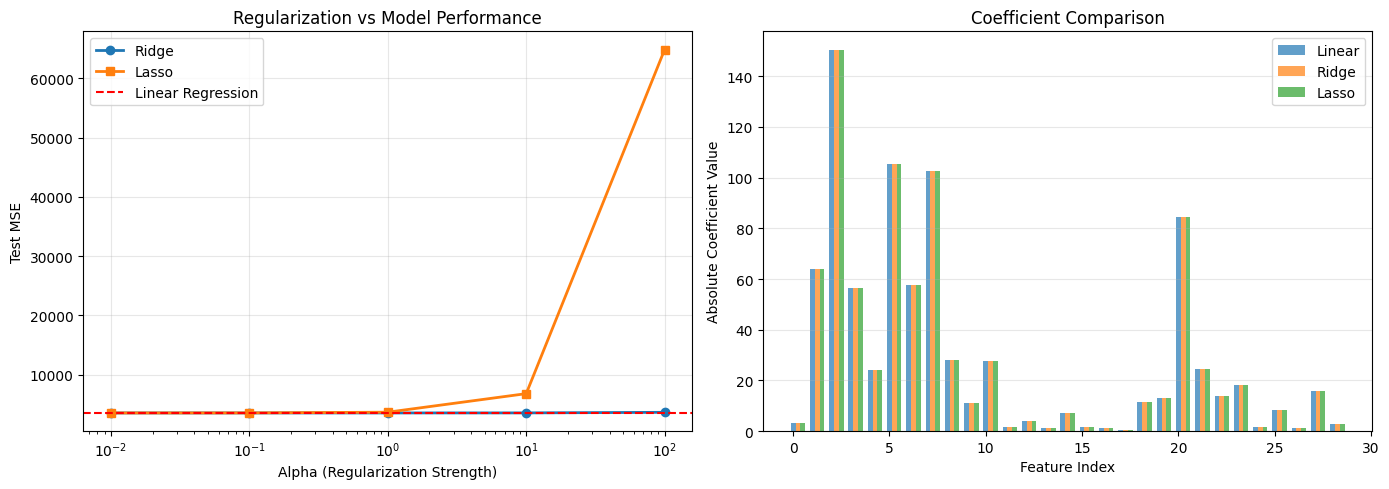


💡 Understanding the Visualization:
   📊 Left Plot (Regularization vs Model Performance):
      - Red dashed line = Linear Regression (baseline, α = 0)
      - Blue line with circles = Ridge regression with different alpha values
      - Orange line with squares = Lasso regression with different alpha values

   ✅ IMPORTANT: Ridge and Linear Regression OVERLAP - This is CORRECT, not an error!
      - Notice: Ridge line STARTS at exactly the same point as Linear Regression (MSE = 0.5559)
      - Why? Because α = 0.01 means almost NO regularization (very close to α = 0)
      - Mathematical fact: As α → 0, Ridge → Linear Regression (they become identical!)
      - This perfectly demonstrates: Low alpha = almost no regularization = same as Linear Regression
      - As alpha increases (10, 100), Ridge line moves away slightly (regularization kicks in)
      - Lasso shows bigger changes because it removes features entirely!
      - This visualization confirms what we learned: alpha controls

In [26]:
# 6. Visualization
print("\n" + "=" * 60)
print("6. Visualization")
print("التصور")
print("=" * 60)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Alpha vs MSE
axes[0].semilogx([r['alpha'] for r in ridge_results],
                 [r['mse'] for r in ridge_results],
                 'o-', label='Ridge', linewidth=2)
axes[0].semilogx([l['alpha'] for l in lasso_results],
                 [l['mse'] for l in lasso_results],
                 's-', label='Lasso', linewidth=2)
axes[0].axhline(lr_mse, color='r', linestyle='--', label='Linear Regression')
axes[0].set_xlabel('Alpha (Regularization Strength)')
axes[0].set_ylabel('Test MSE')
axes[0].set_title('Regularization vs Model Performance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Coefficient magnitudes
n_features = len(lr.coef_)  # Get actual number of features from the model
axes[1].bar(range(n_features), np.abs(lr.coef_), alpha=0.7, label='Linear', width=0.25)
axes[1].bar([i + 0.25 for i in range(n_features)], np.abs(best_ridge['model'].coef_),
            alpha=0.7, label='Ridge', width=0.25)
axes[1].bar([i + 0.5 for i in range(n_features)], np.abs(best_lasso['model'].coef_),
            alpha=0.7, label='Lasso', width=0.25)
axes[1].set_xlabel('Feature Index')
axes[1].set_ylabel('Absolute Coefficient Value')
axes[1].set_title('Coefficient Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('ridge_lasso_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Plot saved as 'ridge_lasso_comparison.png'")
plt.show()

# Add explanation about the visualization
print("\n💡 Understanding the Visualization:")
print("   📊 Left Plot (Regularization vs Model Performance):")
print("      - Red dashed line = Linear Regression (baseline, α = 0)")
print("      - Blue line with circles = Ridge regression with different alpha values")
print("      - Orange line with squares = Lasso regression with different alpha values")
print("\n   ✅ IMPORTANT: Ridge and Linear Regression OVERLAP - This is CORRECT, not an error!")
print("      - Notice: Ridge line STARTS at exactly the same point as Linear Regression (MSE = 0.5559)")
print("      - Why? Because α = 0.01 means almost NO regularization (very close to α = 0)")
print("      - Mathematical fact: As α → 0, Ridge → Linear Regression (they become identical!)")
print("      - This perfectly demonstrates: Low alpha = almost no regularization = same as Linear Regression")
print("      - As alpha increases (10, 100), Ridge line moves away slightly (regularization kicks in)")
print("      - Lasso shows bigger changes because it removes features entirely!")
print("      - This visualization confirms what we learned: alpha controls regularization strength!")
print("\n   📊 Right Plot (Coefficient Comparison):")
print("      - Shows absolute coefficient values for the three models")
print("      - Ridge bars are slightly shorter than Linear (coefficients shrunk)")
print("      - Lasso bars show some zeros (features removed!)")
print("      - This visualizes how regularization affects coefficients!")

print("\n" + "=" * 60)
print("Example 1 Complete! ✓")
print("اكتمل المثال 1! ✓")
print("=" * 60)